# Import

In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
sns.set(context='talk', style='ticks', color_codes=True)

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina

from scipy.spatial import distance_matrix 
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold

from IPython.display import display
from IPython.display import SVG, HTML
from rdkit.Chem.Draw import IPythonConsole
# IPythonConsole.ipython_useSVG = True  # Change output to SVG
# IPythonConsole.drawOptions.addAtomIndices = True

In [2]:
from UQtools import *

In [3]:
base_dir = os.path.dirname(os.path.realpath('__file__')).replace('/scripts/uncertaintyEstimates', '')
base_dir

'/Users/nicolairee/KU_data/esnuelML/ESNUEL_ML'

# Load data

In [4]:
df = pd.read_csv(os.path.join(base_dir, 'data/uncertaintyEstimates/nuc_test_UQres.csv'))
print(df.shape[0])
df.head(2)

97629


,Y_true,Y_pred,Y_pred_RF,Y_pred_1KNN,Y_pred_10KNN,RF_DT_std,1KNNdistsP1,1KNNdistsP2,10KNNdistsP1,10KNNdistsP2
0,386.251939,389.390858,395.192490,409.122308,384.273274,10.019401,0.11813,0.064343,0.209252,0.125213
1,381.109032,355.650156,361.583165,352.919191,352.571182,14.171163,0.05084,0.021347,0.104735,0.045671


# Calculate UQ metrics

## LightGBM predictor

### RF_DT_std

In [15]:
sigmas = df['RF_DT_std']
errors = df['Y_pred'] - df['Y_true']

#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(sigmas, errors)
ordered_df.head(2)

,uq,errors,abs_z
52883,0.886337,-17.966701,20.270729
54870,1.114205,0.413903,0.371479


R-squared: 0.9965481035034792
Intercept: 4.044501905413345
Slope: 0.6028123658016926


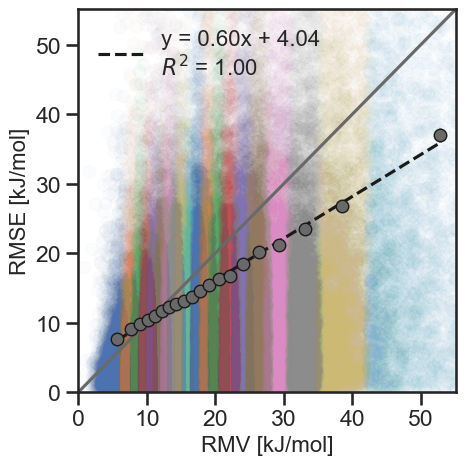

In [25]:
Nbins = 20
N_total = len(ordered_df['uq'])
N_entries = math.ceil(N_total/Nbins)

rmvs, rmses, ci_low, ci_high = get_rmvs_and_rmses(ordered_df['uq'], ordered_df['errors'], Nbins=Nbins, include_bootstrap=True)

x = np.array(rmvs)
y = np.array(rmses)

# Obtain the coefficient of determination by calling the model with the score() function, then print the coefficient:
slope, intercept, r_value, p_value, std_err = ss.linregress(x, y)
r_sq = r_value**2
print('R-squared:', r_sq)

# Print the Intercept:
print('Intercept:', intercept)

# Print the Slope:
print('Slope:', slope) 

# Predict a Response and print it:
# y_pred = model.predict(x)
y_pred = slope * x + intercept

fig, ax = plt.subplots(figsize=(5, 5))
assymetric_errors = [np.array(rmses)-np.array(ci_low), np.array(ci_high)-np.array(rmses)]
ax.errorbar(x, y, yerr = assymetric_errors, fmt="o", color='dimgrey', markeredgecolor='k', linewidth=2)

if ax.get_xlim()[-1] > ax.get_ylim()[-1]:
    plt.xlim(0,ax.get_xlim()[-1])
    plt.ylim(0,ax.get_xlim()[-1])
    ax.plot(np.arange(0,ax.get_xlim()[-1],0.01),np.arange(0,ax.get_xlim()[-1],0.01), linestyle='-', color='dimgrey')
    plt.xticks(np.arange(0,ax.get_xlim()[-1]+1,10))
    plt.yticks(np.arange(0,ax.get_xlim()[-1]+1,10))
else:
    plt.xlim(0,ax.get_ylim()[-1])
    plt.ylim(0,ax.get_ylim()[-1])
    ax.plot(np.arange(0,ax.get_ylim()[-1],0.01),np.arange(0,ax.get_ylim()[-1],0.01), linestyle='-', color='dimgrey')
    plt.xticks(np.arange(0,ax.get_ylim()[-1]+1,10))
    plt.yticks(np.arange(0,ax.get_ylim()[-1]+1,10))


x2 = [ordered_df['uq'][i:i+N_entries].tolist() for i in range(0, N_total, N_entries)]
y2 = [abs(ordered_df['errors'][i:i+N_entries]).tolist() for i in range(0, N_total, N_entries)]
for i in range(Nbins):
    sns.scatterplot(x="x2", y="y2", data=pd.DataFrame(np.column_stack((x2[i],y2[i])), columns=["x2", "y2"]), markers='.', alpha=0.02, edgecolors=None, rasterized=True)
    # plt.plot(np.median(x2[i]),np.median(y2[i]), 'ro', markeredgecolor='k')

if intercept >= 0:
    ax.plot(rmvs, slope * np.array(rmvs) + intercept, linestyle="dashed", color='k', label="y = {:0.2f}".format(slope)+"x + {:0.2f}\n".format(intercept) + r'$R^2$ = '"{:0.2f}".format(r_sq))
else:
    ax.plot(rmvs, slope * np.array(rmvs) + intercept, linestyle="dashed", color='k', label="y = {:0.2f}".format(slope)+"x - {:0.2f}\n".format(intercept) + r'$R^2$ = '"{:0.2f}".format(r_sq))

ax.set_xlabel("RMV [kJ/mol]", fontsize=16)
ax.set_ylabel("RMSE [kJ/mol]", fontsize=16)
ax.legend(loc=2, fontsize=16, frameon=False)
if ax.get_xlim()[-1] > ax.get_ylim()[-1]:
    plt.xlim(0,ax.get_xlim()[-1])
    plt.ylim(0,ax.get_xlim()[-1])
else:
    plt.xlim(0,ax.get_ylim()[-1])
    plt.ylim(0,ax.get_ylim()[-1])

plt.tight_layout()
plt.savefig('figures/nuc_RF_DT_std_slope_metric_withColoring.pdf')
plt.show()

miscalibration area = 0.09
R-squared: 0.9965481035034792
Intercept: 4.044501905413345
Slope: 0.6028123658016926


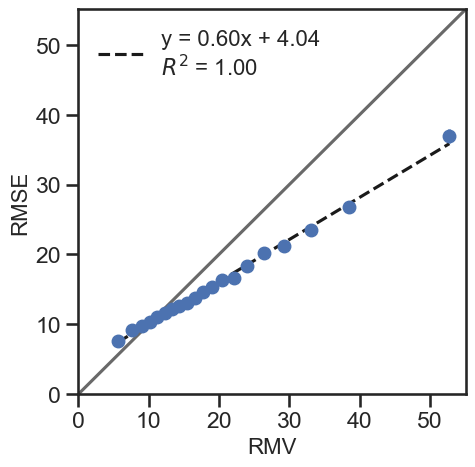

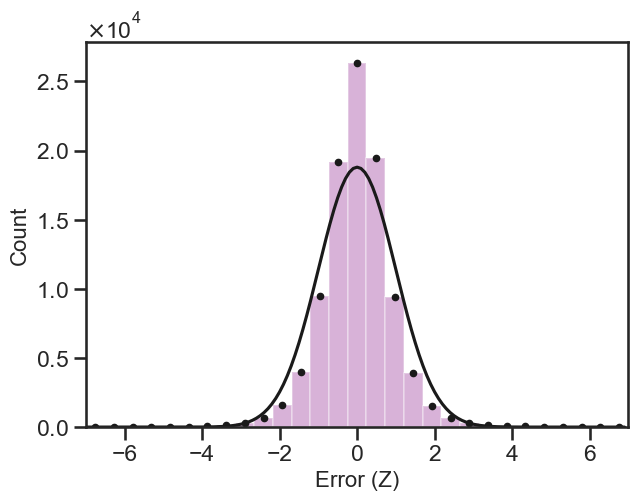

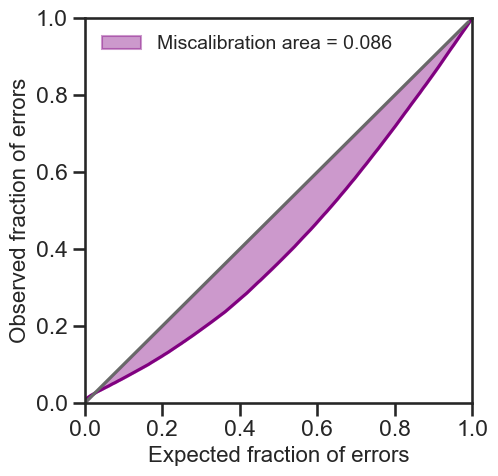

In [17]:
#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#generate error-based calibration plot
fig1, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)

In [7]:
fig1.tight_layout()
fig1.savefig('figures/nuc_RF_DT_std_slope_metric.pdf')

fig2.tight_layout()
fig2.savefig('figures/nuc_RF_DT_std_Z_scores.pdf')

fig3.tight_layout()
fig3.savefig('figures/nuc_RF_DT_std_calibration_curve.pdf')

In [32]:
#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(ordered_df.errors), ordered_df.uq)
print(f'rho_rank = {rho_rank:.2f}')
exp_rhos_temp = []
for i in range(1000):
    exp_rho, _ = expected_rho(ordered_df.uq)
    exp_rhos_temp.append(exp_rho)
rho_rank_sim = np.mean(exp_rhos_temp)
rho_rank_sim_std = np.std(exp_rhos_temp)
print(f'rho_rank_sim = {rho_rank_sim:.2f} +/- {rho_rank_sim_std:.2f}')

#Calculate NLL and simulated NLL
_NLL = NLL(ordered_df.uq, ordered_df.errors)
print(f'NLL = {_NLL:.2f}')
exp_NLL = []
for i in range(1000):
    sim_errors = []
    for sigma in ordered_df.uq:
        sim_error = np.random.normal(0, sigma)
        sim_errors.append(sim_error)
    NLL_sim = NLL(ordered_df.uq, sim_errors)
    exp_NLL.append(NLL_sim)
NLL_sim = np.mean(exp_NLL)
NLL_sim_std = np.std(exp_NLL)
print(f'NLL_sim = {NLL_sim:.2f} +/- {NLL_sim_std:.2f}')

rho_rank = 0.36
rho_rank_sim = 0.49 +/- 0.00
NLL = 4.17
NLL_sim = 4.26 +/- 0.00


### 1KNNdistsP1

In [42]:
sigmas = df['1KNNdistsP1']
errors = df['Y_pred'] - df['Y_true']

#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(sigmas, errors)
ordered_df.head(2)

,uq,errors,abs_z
70534,0.0,1.302092,inf
49338,0.0,2.027162,inf


miscalibration area = 0.49
R-squared: 0.9014556995949778
Intercept: 13.286848926709252
Slope: 16.092942876569477


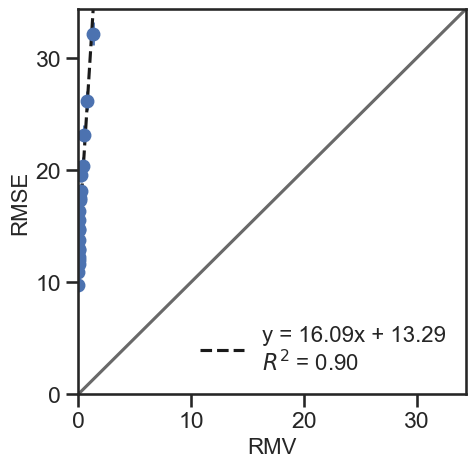

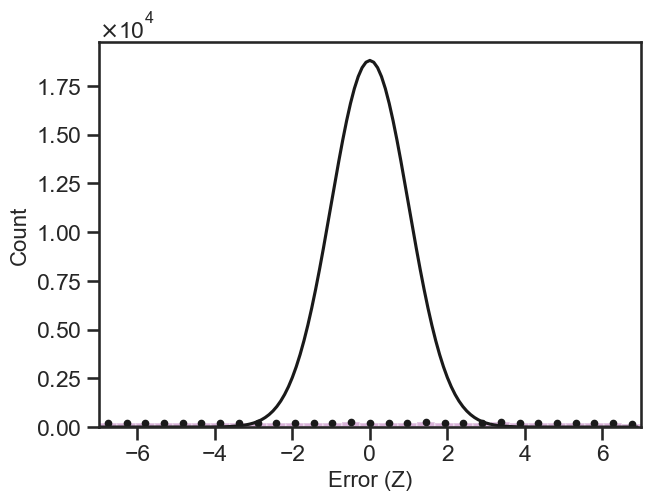

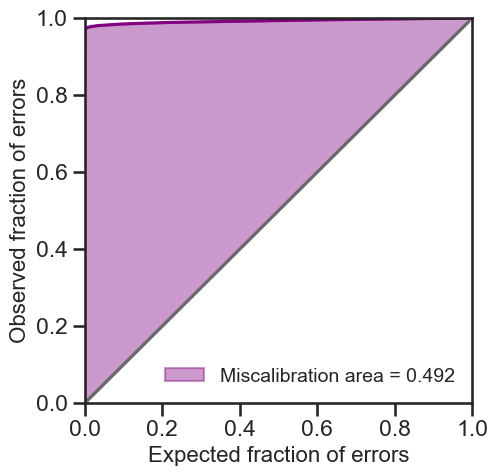

In [43]:
#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#generate error-based calibration plot
fig1, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)

In [44]:
#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(ordered_df.errors), ordered_df.uq)
print(f'rho_rank = {rho_rank:.2f}')
exp_rhos_temp = []
for i in range(1000):
    exp_rho, _ = expected_rho(ordered_df.uq)
    exp_rhos_temp.append(exp_rho)
rho_rank_sim = np.mean(exp_rhos_temp)
rho_rank_sim_std = np.std(exp_rhos_temp)
print(f'rho_rank_sim = {rho_rank_sim:.2f} +/- {rho_rank_sim_std:.2f}')

# #Calculate NLL and simulated NLL
# _NLL = NLL(ordered_df.uq, ordered_df.errors)
# print(f'NLL = {_NLL:.2f}')
# exp_NLL = []
# for i in range(1000):
#     sim_errors = []
#     for sigma in ordered_df.uq:
#         sim_error = np.random.normal(0, sigma)
#         sim_errors.append(sim_error)
#     NLL_sim = NLL(ordered_df.uq, sim_errors)
#     exp_NLL.append(NLL_sim)
# NLL_sim = np.mean(exp_NLL)
# NLL_sim_std = np.std(exp_NLL)
# print(f'NLL_sim = {NLL_sim:.2f} +/- {NLL_sim_std:.2f}')

rho_rank = 0.29
rho_rank_sim = 0.84 +/- 0.00


ValueError: math domain error

### 1KNNdistsP2

In [47]:
sigmas = df['1KNNdistsP2']
errors = df['Y_pred'] - df['Y_true']

#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(sigmas, errors)
ordered_df.head(2)

,uq,errors,abs_z
96114,0.0,-4.422469,inf
10037,0.0,0.055159,inf


miscalibration area = 0.50
R-squared: 0.9310784431947504
Intercept: 12.964801795071166
Slope: 43.97013453903256


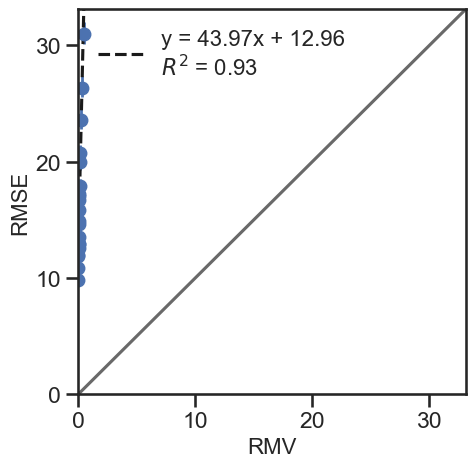

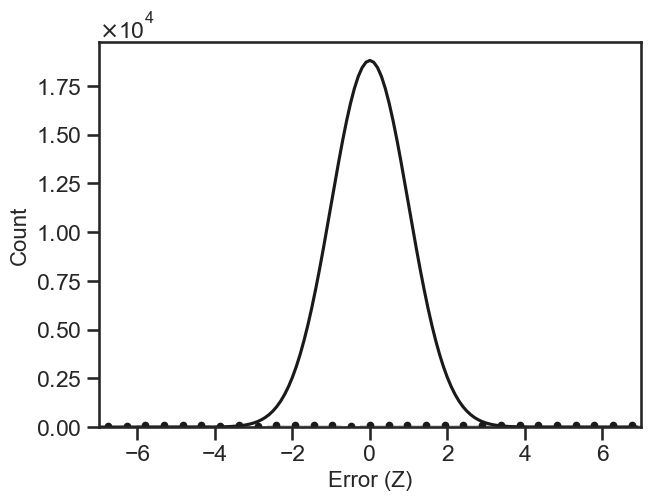

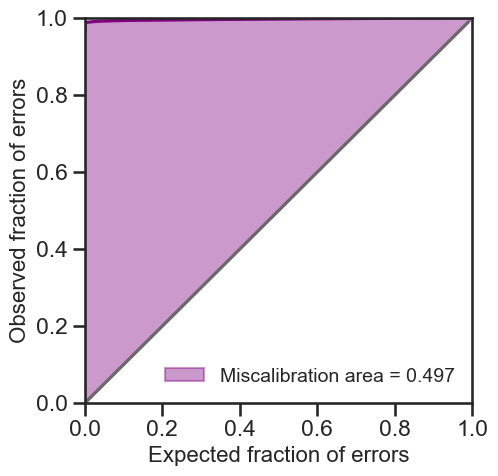

In [48]:
#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#generate error-based calibration plot
fig1, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)

In [49]:
#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(ordered_df.errors), ordered_df.uq)
print(f'rho_rank = {rho_rank:.2f}')
exp_rhos_temp = []
for i in range(1000):
    exp_rho, _ = expected_rho(ordered_df.uq)
    exp_rhos_temp.append(exp_rho)
rho_rank_sim = np.mean(exp_rhos_temp)
rho_rank_sim_std = np.std(exp_rhos_temp)
print(f'rho_rank_sim = {rho_rank_sim:.2f} +/- {rho_rank_sim_std:.2f}')

# #Calculate NLL and simulated NLL
# _NLL = NLL(ordered_df.uq, ordered_df.errors)
# print(f'NLL = {_NLL:.2f}')
# exp_NLL = []
# for i in range(1000):
#     sim_errors = []
#     for sigma in ordered_df.uq:
#         sim_error = np.random.normal(0, sigma)
#         sim_errors.append(sim_error)
#     NLL_sim = NLL(ordered_df.uq, sim_errors)
#     exp_NLL.append(NLL_sim)
# NLL_sim = np.mean(exp_NLL)
# NLL_sim_std = np.std(exp_NLL)
# print(f'NLL_sim = {NLL_sim:.2f} +/- {NLL_sim_std:.2f}')

rho_rank = 0.29
rho_rank_sim = 0.85 +/- 0.00


ValueError: math domain error

### 10KNNdistsP1

In [62]:
sigmas = df['10KNNdistsP1']
errors = df['Y_pred'] - df['Y_true']

#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(sigmas, errors)
ordered_df.head(2)

,uq,errors,abs_z
56551,0.001494,-12.770566,8547.902582
93866,0.001523,2.035048,1336.210032


miscalibration area = 0.48
R-squared: 0.981136409627695
Intercept: 12.086181871833542
Slope: 11.89190612511582


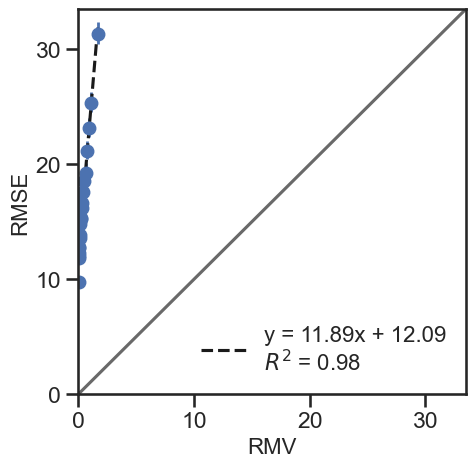

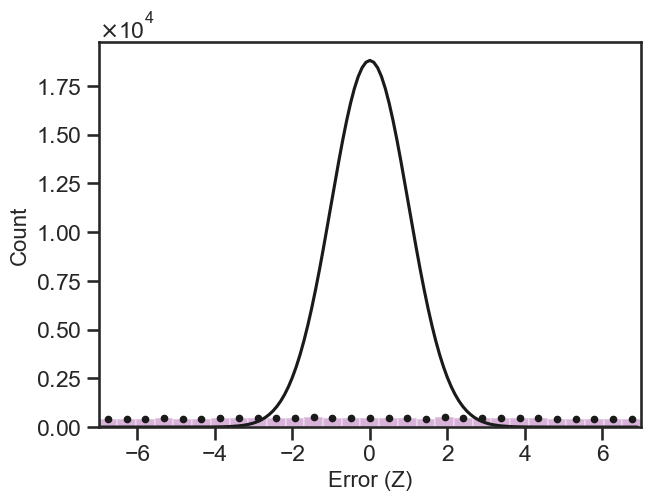

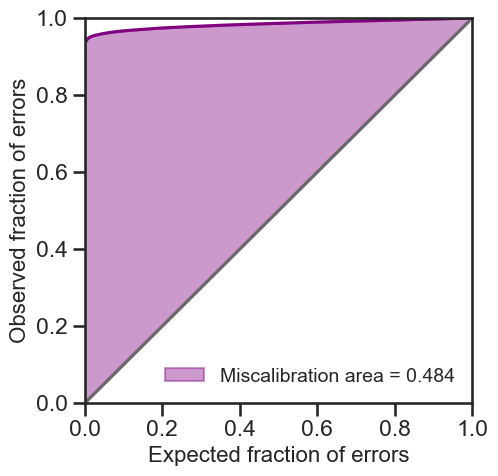

In [63]:
#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#generate error-based calibration plot
fig1, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)

In [64]:
#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(ordered_df.errors), ordered_df.uq)
print(f'rho_rank = {rho_rank:.2f}')
exp_rhos_temp = []
for i in range(1000):
    exp_rho, _ = expected_rho(ordered_df.uq)
    exp_rhos_temp.append(exp_rho)
rho_rank_sim = np.mean(exp_rhos_temp)
rho_rank_sim_std = np.std(exp_rhos_temp)
print(f'rho_rank_sim = {rho_rank_sim:.2f} +/- {rho_rank_sim_std:.2f}')

#Calculate NLL and simulated NLL
_NLL = NLL(ordered_df.uq, ordered_df.errors)
print(f'NLL = {_NLL:.2f}')
exp_NLL = []
for i in range(1000):
    sim_errors = []
    for sigma in ordered_df.uq:
        sim_error = np.random.normal(0, sigma)
        sim_errors.append(sim_error)
    NLL_sim = NLL(ordered_df.uq, sim_errors)
    exp_NLL.append(NLL_sim)
NLL_sim = np.mean(exp_NLL)
NLL_sim_std = np.std(exp_NLL)
print(f'NLL_sim = {NLL_sim:.2f} +/- {NLL_sim_std:.2f}')

rho_rank = 0.27
rho_rank_sim = 0.80 +/- 0.00
NLL = 56590.80
NLL_sim = -0.29 +/- 0.00


### 10KNNdistsP2

In [65]:
sigmas = df['10KNNdistsP2']
errors = df['Y_pred'] - df['Y_true']

#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(sigmas, errors)
ordered_df.head(2)

,uq,errors,abs_z
93866,0.000559,2.035048,3638.171125
53183,0.000612,3.817571,6242.744278


miscalibration area = 0.49
R-squared: 0.9869256567611676
Intercept: 11.683699822571088
Slope: 33.28629861597322


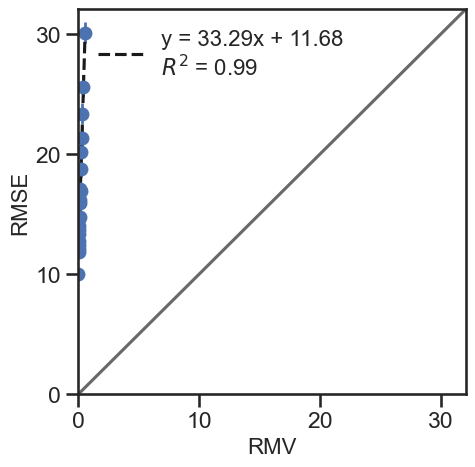

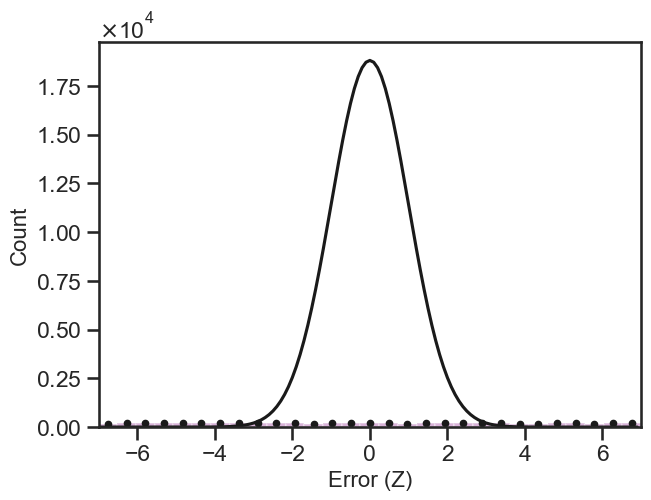

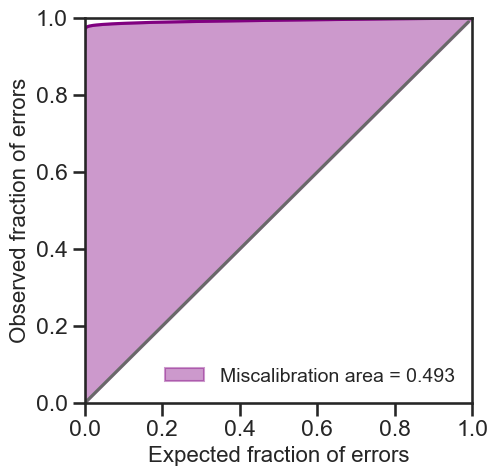

In [66]:
#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#generate error-based calibration plot
fig1, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)

In [67]:
#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(ordered_df.errors), ordered_df.uq)
print(f'rho_rank = {rho_rank:.2f}')
exp_rhos_temp = []
for i in range(1000):
    exp_rho, _ = expected_rho(ordered_df.uq)
    exp_rhos_temp.append(exp_rho)
rho_rank_sim = np.mean(exp_rhos_temp)
rho_rank_sim_std = np.std(exp_rhos_temp)
print(f'rho_rank_sim = {rho_rank_sim:.2f} +/- {rho_rank_sim_std:.2f}')

#Calculate NLL and simulated NLL
_NLL = NLL(ordered_df.uq, ordered_df.errors)
print(f'NLL = {_NLL:.2f}')
exp_NLL = []
for i in range(1000):
    sim_errors = []
    for sigma in ordered_df.uq:
        sim_error = np.random.normal(0, sigma)
        sim_errors.append(sim_error)
    NLL_sim = NLL(ordered_df.uq, sim_errors)
    exp_NLL.append(NLL_sim)
NLL_sim = np.mean(exp_NLL)
NLL_sim_std = np.std(exp_NLL)
print(f'NLL_sim = {NLL_sim:.2f} +/- {NLL_sim_std:.2f}')

rho_rank = 0.26
rho_rank_sim = 0.79 +/- 0.00
NLL = 351632.51
NLL_sim = -1.15 +/- 0.00


### Pred. std

In [ ]:
sigmas = np.std(list(zip(df['Y_pred'], df['Y_pred_RF'], df['Y_pred_1KNN'], df['Y_pred_10KNN'])), ddof=1, axis=1)
errors = df['Y_pred'] - df['Y_true']

#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(sigmas, errors)
ordered_df.head(2)

,uq,errors,abs_z
22113,0.059107,4.930501,83.416856
28178,0.093099,-0.189788,2.038557


miscalibration area = 0.12
R-squared: 0.8989057360745093
Intercept: 11.312312240374538
Slope: 0.42186176097213585


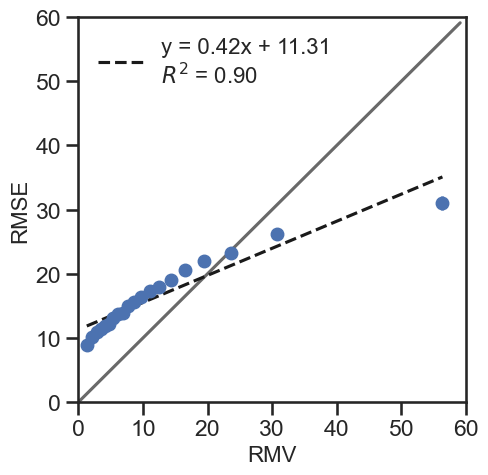

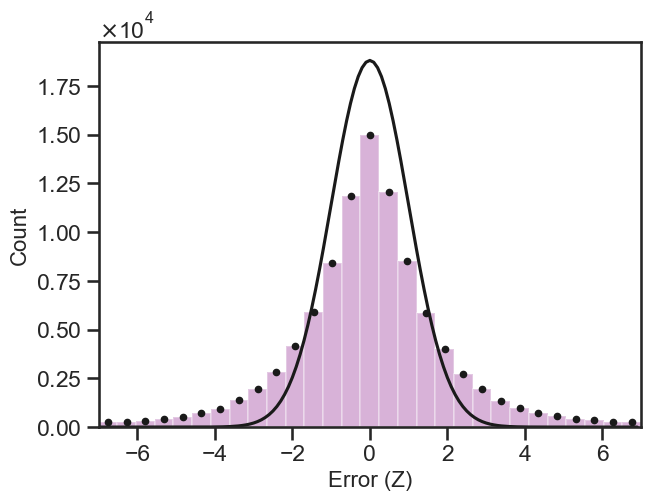

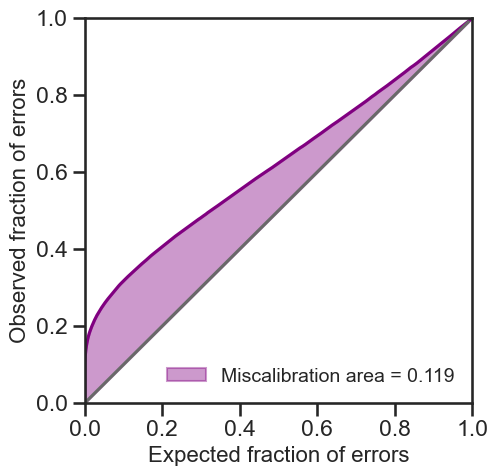

In [ ]:
#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#generate error-based calibration plot
fig1, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)

In [35]:
#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(ordered_df.errors), ordered_df.uq)
print(f'rho_rank = {rho_rank:.2f}')
exp_rhos_temp = []
for i in range(1000):
    exp_rho, _ = expected_rho(ordered_df.uq)
    exp_rhos_temp.append(exp_rho)
rho_rank_sim = np.mean(exp_rhos_temp)
rho_rank_sim_std = np.std(exp_rhos_temp)
print(f'rho_rank_sim = {rho_rank_sim:.2f} +/- {rho_rank_sim_std:.2f}')

#Calculate NLL and simulated NLL
_NLL = NLL(ordered_df.uq, ordered_df.errors)
print(f'NLL = {_NLL:.2f}')
exp_NLL = []
for i in range(1000):
    sim_errors = []
    for sigma in ordered_df.uq:
        sim_error = np.random.normal(0, sigma)
        sim_errors.append(sim_error)
    NLL_sim = NLL(ordered_df.uq, sim_errors)
    exp_NLL.append(NLL_sim)
NLL_sim = np.mean(exp_NLL)
NLL_sim_std = np.std(exp_NLL)
print(f'NLL_sim = {NLL_sim:.2f} +/- {NLL_sim_std:.2f}')

rho_rank = 0.31
rho_rank_sim = 0.67 +/- 0.00
NLL = 7.76
NLL_sim = 3.51 +/- 0.00


## Random forest predictor

### RF_DT_std

In [23]:
sigmas = df['RF_DT_std']
errors = df['Y_pred_RF'] - df['Y_true']

#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(sigmas, errors)
ordered_df.head(2)

,uq,errors,abs_z
52883,0.886337,-19.040124,21.481806
54870,1.114205,-0.240644,0.215978


miscalibration area = 0.08
R-squared: 0.9920866521877338
Intercept: 1.913084135686331
Slope: 0.749897274462919


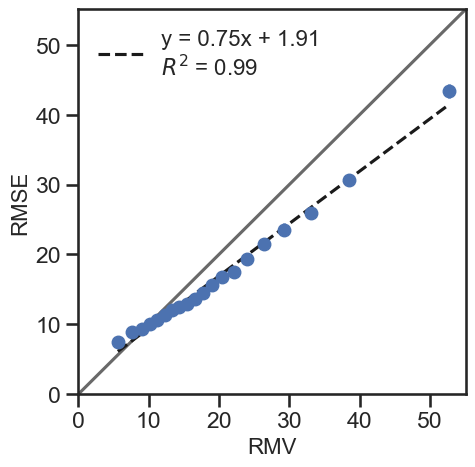

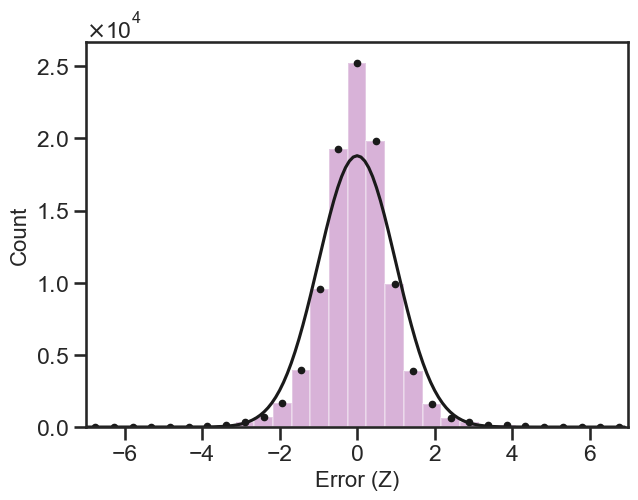

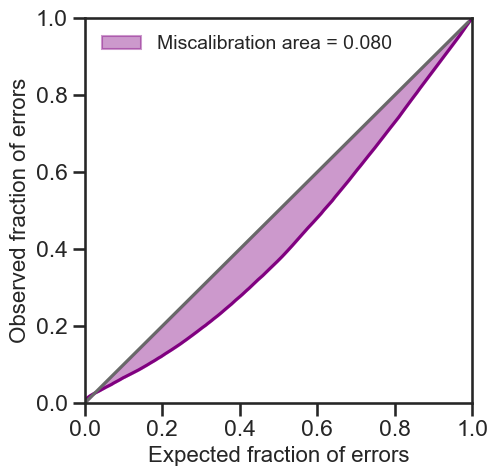

In [24]:
#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#generate error-based calibration plot
fig1, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)

In [10]:
fig1.tight_layout()
fig1.savefig('figures/nuc_RF_RF_DT_std_slope_metric.pdf')

fig2.tight_layout()
fig2.savefig('figures/nuc_RF_RF_DT_std_Z_scores.pdf')

fig3.tight_layout()
fig3.savefig('figures/nuc_RF_RF_DT_std_calibration_curve.pdf')

In [ ]:
#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(ordered_df.errors), ordered_df.uq)
print(f'rho_rank = {rho_rank:.2f}')

#Calculate NLL and simulated NLL
_NLL = NLL(ordered_df.uq, ordered_df.errors)
print(f'NLL = {_NLL:.2f}')

rho_rank = 0.44
rho_rank_sim = 0.49 +/- 0.00
NLL = 4.17
NLL_sim = 4.26 +/- 0.00


### 1KNNdistsP1

In [50]:
sigmas = df['1KNNdistsP1']
errors = df['Y_pred_RF'] - df['Y_true']

#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(sigmas, errors)
ordered_df.head(2)

,uq,errors,abs_z
70534,0.0,-1.111301,inf
49338,0.0,0.459873,inf


miscalibration area = 0.49
R-squared: 0.9063584274838011
Intercept: 13.514130710422336
Slope: 20.107539264543263


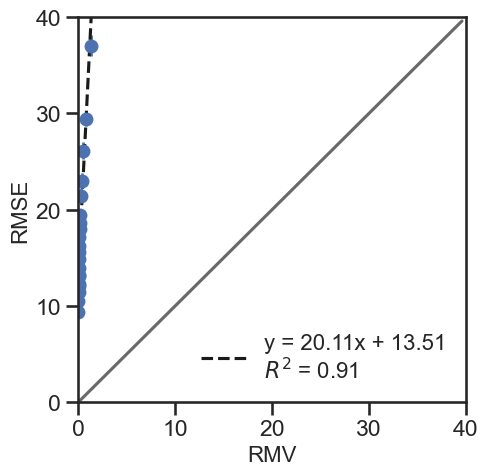

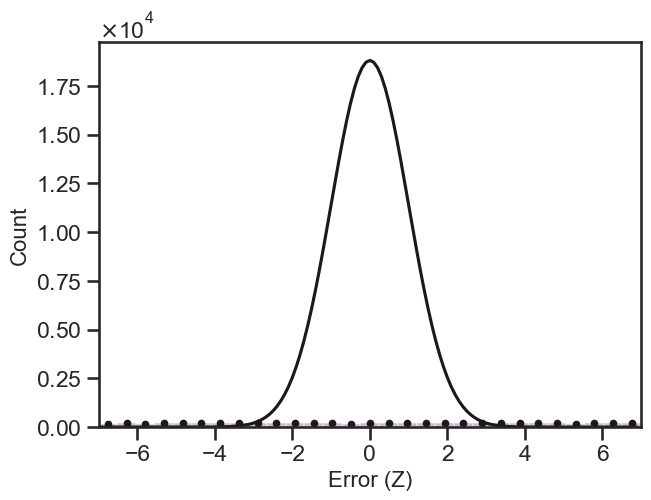

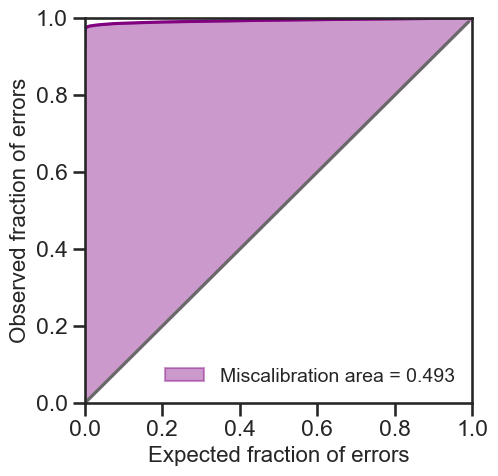

In [51]:
#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#generate error-based calibration plot
fig1, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)

In [52]:
#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(ordered_df.errors), ordered_df.uq)
print(f'rho_rank = {rho_rank:.2f}')

# #Calculate NLL and simulated NLL
# _NLL = NLL(ordered_df.uq, ordered_df.errors)
# print(f'NLL = {_NLL:.2f}')

rho_rank = 0.33


ValueError: math domain error

### 1KNNdistsP2

In [53]:
sigmas = df['1KNNdistsP2']
errors = df['Y_pred_RF'] - df['Y_true']

#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(sigmas, errors)
ordered_df.head(2)

,uq,errors,abs_z
96114,0.0,11.860508,inf
10037,0.0,-0.120250,inf


miscalibration area = 0.50
R-squared: 0.9403396480191883
Intercept: 13.103502238065435
Slope: 55.10261252051841


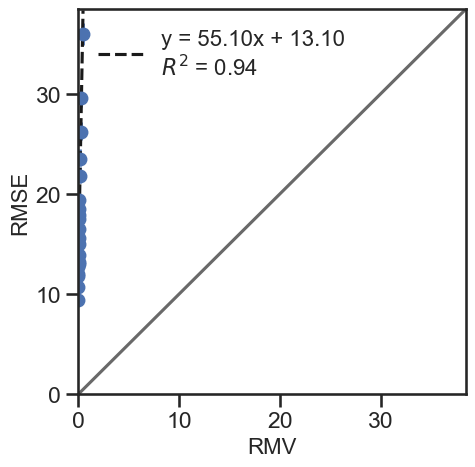

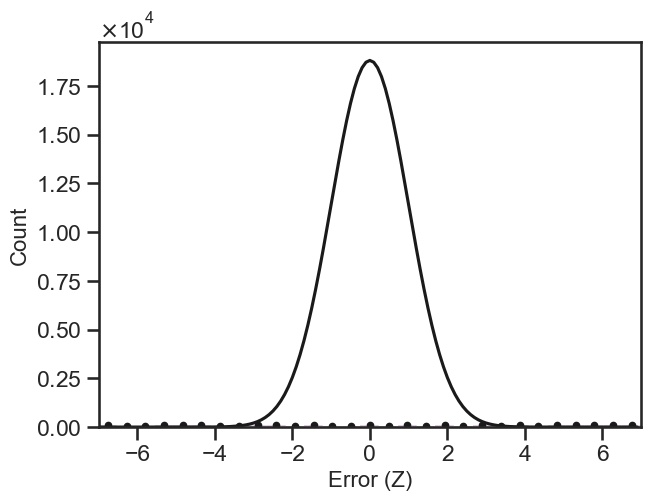

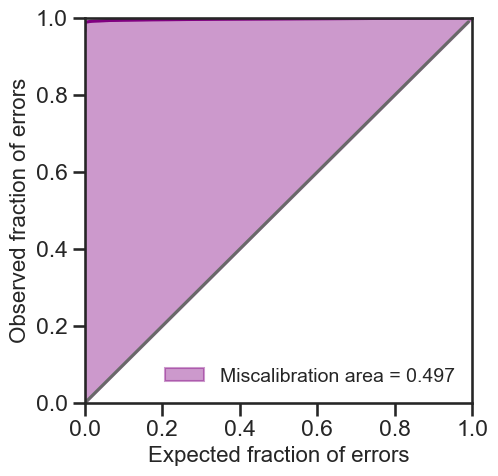

In [54]:
#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#generate error-based calibration plot
fig1, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)

In [55]:
#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(ordered_df.errors), ordered_df.uq)
print(f'rho_rank = {rho_rank:.2f}')

# #Calculate NLL and simulated NLL
# _NLL = NLL(ordered_df.uq, ordered_df.errors)
# print(f'NLL = {_NLL:.2f}')

rho_rank = 0.33


ValueError: math domain error

### 10KNNdistsP1

In [56]:
sigmas = df['10KNNdistsP1']
errors = df['Y_pred_RF'] - df['Y_true']

#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(sigmas, errors)
ordered_df.head(2)

,uq,errors,abs_z
56551,0.001494,-4.307565,2883.243291
93866,0.001523,3.357415,2204.474869


miscalibration area = 0.49
R-squared: 0.9836769581982653
Intercept: 12.137026178354937
Slope: 14.65855080194392


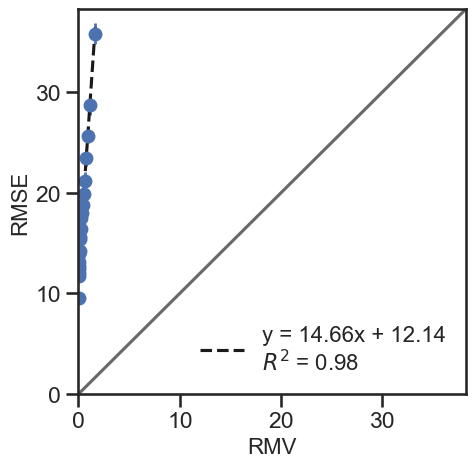

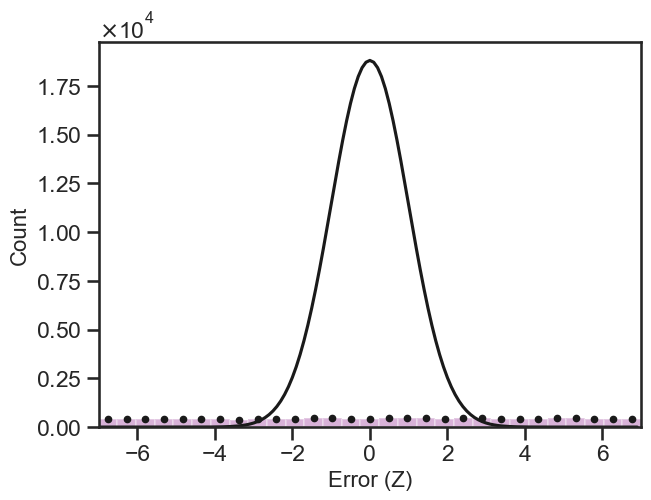

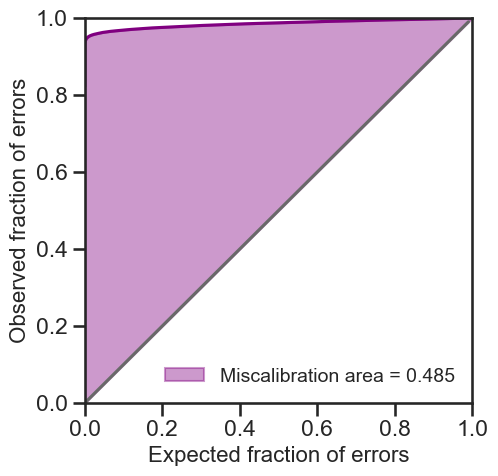

In [57]:
#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#generate error-based calibration plot
fig1, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)

In [58]:
#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(ordered_df.errors), ordered_df.uq)
print(f'rho_rank = {rho_rank:.2f}')

#Calculate NLL and simulated NLL
_NLL = NLL(ordered_df.uq, ordered_df.errors)
print(f'NLL = {_NLL:.2f}')

rho_rank = 0.31
NLL = 53016.10


### 10KNNdistsP2

In [59]:
sigmas = df['10KNNdistsP2']
errors = df['Y_pred_RF'] - df['Y_true']

#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(sigmas, errors)
ordered_df.head(2)

,uq,errors,abs_z
93866,0.000559,3.357415,6002.242626
53183,0.000612,-3.834257,6270.031377


miscalibration area = 0.49
R-squared: 0.9894520272908086
Intercept: 11.641963338635865
Slope: 41.067967529845866


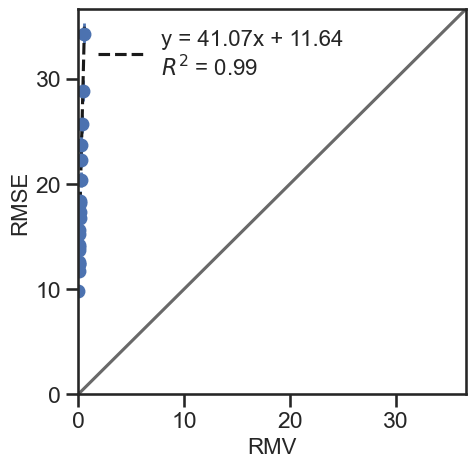

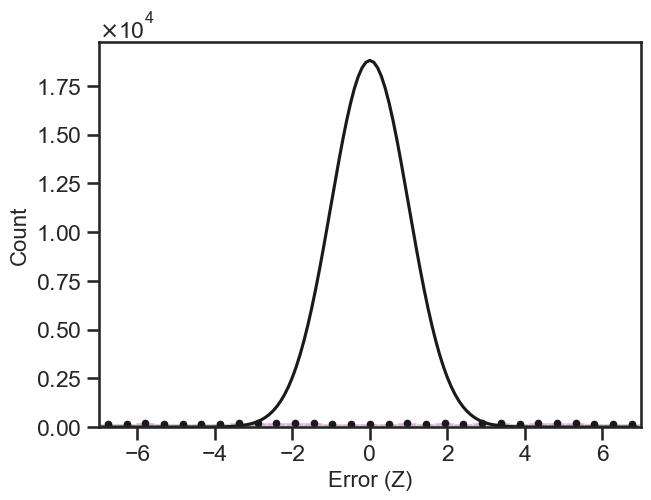

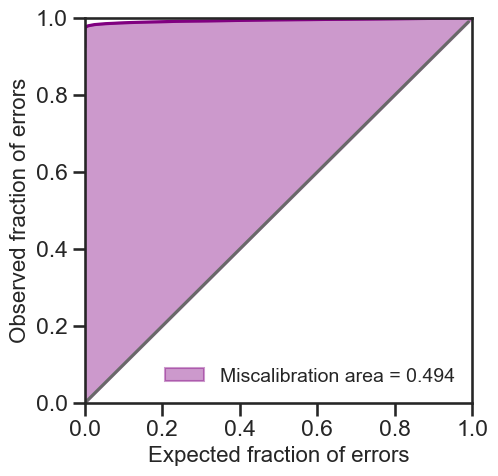

In [60]:
#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#generate error-based calibration plot
fig1, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)

In [61]:
#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(ordered_df.errors), ordered_df.uq)
print(f'rho_rank = {rho_rank:.2f}')

#Calculate NLL and simulated NLL
_NLL = NLL(ordered_df.uq, ordered_df.errors)
print(f'NLL = {_NLL:.2f}')

rho_rank = 0.30
NLL = 335682.87


### Pred. std

In [ ]:
sigmas = np.std(list(zip(df['Y_pred'], df['Y_pred_RF'], df['Y_pred_1KNN'], df['Y_pred_10KNN'])), ddof=1, axis=1)
errors = df['Y_pred_RF'] - df['Y_true']

#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(sigmas, errors)
ordered_df.head(2)

,uq,errors,abs_z
22113,0.059107,4.894676,82.810735
28178,0.093099,-0.177563,1.907252


miscalibration area = 0.13
R-squared: 0.9064207116170888
Intercept: 11.028954077592186
Slope: 0.5276841117687167


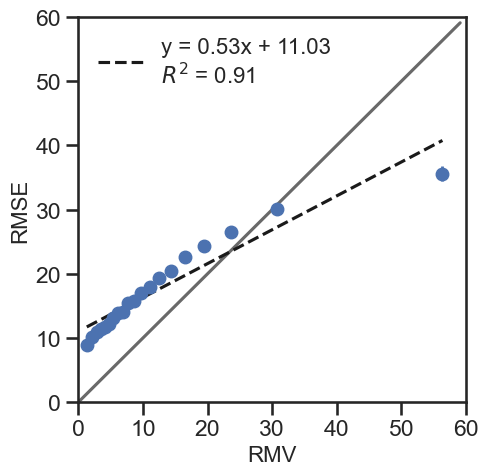

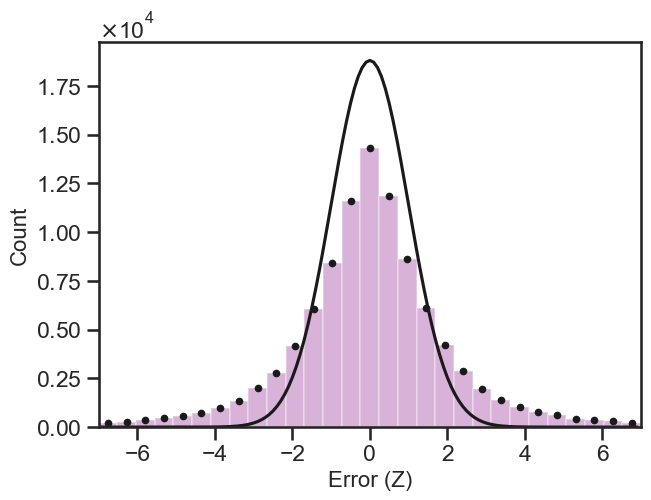

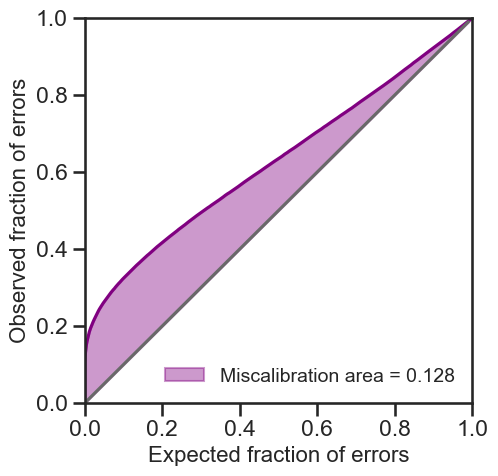

In [ ]:
#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#generate error-based calibration plot
fig1, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)

In [ ]:
#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(ordered_df.errors), ordered_df.uq)
print(f'rho_rank = {rho_rank:.2f}')

#Calculate NLL and simulated NLL
_NLL = NLL(ordered_df.uq, ordered_df.errors)
print(f'NLL = {_NLL:.2f}')

rho_rank = 0.36
rho_rank_sim = 0.67 +/- 0.00
NLL = 7.80
NLL_sim = 3.51 +/- 0.00
